In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output


In [2]:
# 1. load data
df = pd.read_csv("./data/processed/df_cleaned_ready_for_modeling.csv", delimiter=",")


In [3]:
# 2. Create target variable (1 = delayed, 0 = not delayed)
df["Delayed"] = df["Dep_Delay"].apply(lambda x: 1 if x > 15 else 0)

In [4]:
# 3. Limit the number of categories to top N
top_n = 50
for col in [
    "Dep_Airport", "Arr_Airport", "Airline", "Tail_Number",
    "Manufacturer", "Model", "Dep_CityName", "Arr_CityName",
    "AIRPORT", "CITY", "STATE", "COUNTRY"
]:
    if col in df.columns:
        top_categories = df[col].value_counts().nlargest(top_n).index
        df[col] = df[col].apply(lambda x: x if x in top_categories else "Other")

In [5]:
# 4. Use as meaningful features
features = [
"FlightDate","Day_Of_Week","Airline","Dep_Airport","DepTime_label","Arr_Airport","Arr_Delay","Flight_Duration","Distance_type","Manufacturer","Aicraft_age","AIRPORT","tavg","tmin","tmax","prcp","snow","wdir","wspd","pres","Cancelled","Diverted","Aircraft_Age_Group"
]

# Extract only relevant columns
data = df[features + ["Delayed"]].dropna()

# Encode categorical variables
data = pd.get_dummies(data, columns=[
"FlightDate","Airline","Dep_Airport","DepTime_label","Arr_Airport","Distance_type","Manufacturer","AIRPORT","Aircraft_Age_Group"
])

In [6]:
# 5. Train-Test-Split
X = data.drop("Delayed", axis=1)
y = data["Delayed"]
# Trainingsmenge reduziert auf 50% zur Beschleunigung des Modelltrainings
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)

In [7]:
# 6. Random Forest Model
model = RandomForestClassifier(n_estimators=30, max_depth=10, n_jobs=-1, class_weight='balanced', random_state=42, verbose=1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=30,
                       n_jobs=-1, random_state=42, verbose=1)

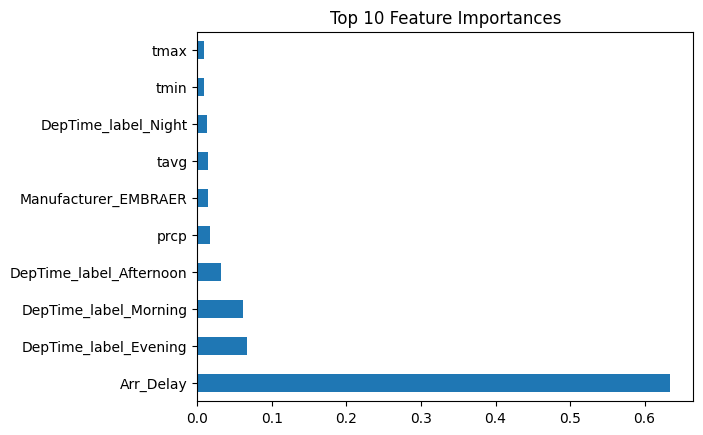

In [8]:
# 8. Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()

In [9]:
# 9. Forecast Function based on user inputs
# Expected Inputs:
# - flight_date (Format: "dd.mm.yyyy")
# - airline (e.g. "Delta Air Lines Inc")
# - dep_airport / arr_airport (IATA codes from an US airport e.g. "ATL" /niche commercial airports and military fields are not allowed )
# - dep_time_label ("Morning", "Afternoon", "Evening", "Night")

def predict_delay_manual(flight_date: str, airline: str, dep_airport: str, dep_time_label: str, arr_airport: str):
    valid_airlines = [
        "Endeavor Air", "American Airlines Inc.", "Alaska Airlines Inc.", "JetBlue Airways",
        "Delta Air Lines Inc", "Frontier Airlines Inc.", "Allegiant Air", "Hawaiian Airlines Inc.",
        "American Eagle Airlines Inc.", "Spirit Air Lines", "Southwest Airlines Co.",
        "Republic Airways", "PSA Airlines", "Skywest Airlines Inc.", "United Air Lines Inc."
    ]

    valid_airports = ["LGA","CVG","BGM","MSP","FAY","ATL","ITH","DTW","PIT","JFK","BWI","CID","SDF","GSP","ILM","EWR","CRW","CHO","DAY","SAV","CLT","RDU","STL","TYS","JAX","DCA","TVC","CLE","CHS","GRR","PVD","DSM","CHA","AUS","LFT","AVL","GRB","ORF","MKE","GNV","MDW","BTV","MBS","BTR","EVV","ALB","MGM","MOT","XNA","VLD","BUF","ROA","MCI","BNA","PHL","MEM","MQT","DLH","SCE","LEX","SYR","BGR","RIC","CWA","CAE","ROC","CMH","GFK","IND","ATW","HPN","CSG","BDL","MDT","MSN","PWM","AZO","ABY","GSO","SGF","BQK","HSV","MLU","AGS","ORD","MYR","AEX","BHM","TRI","DHN","GPT","GTR","LAN","LSE","JAN","ABE","SHV","FSD","OMA","MOB","IAD","EYW","ORH","MSY","DFW","ICT","MIA","LAX","OGG","HNL","KOA","SFO","SJC","JAC","LAS","SNA","PHX","LIH","BOS","ELP","SLC","SAN","GEG","SEA","STT","MFE","SJU","IAH","FLL","ANC","MCO","DEN","TPA","SAT","TUL","SMF","EGE","COS","EUG","OKC","PBI","ABQ","ECP","PNS","ONT","SRQ","TUS","BZN","FAT","RNO","GUC","RSW","HDN","LIT","PDX","PSP","MTJ","LBB","BOI","SBA","BUR","DAB","VPS","MSO","AMA","BFL","SBP","AVP","STX","SIT","KTN","JNU","DAL","FAI","PAE","STS","RDM","OAK","BET","BRW","OTZ","CDV","YAK","PSG","WRG","SCC","OME","ADQ","ADK","BQN","PSE","TLH","FCA","BIS","MLB","FAR","RST","HOU","OAJ","BIL","PSC","ISP","SWF","BMI","TTN","SFB","PGD","AZA","LRD","PVU","HGR","PIE","BLV","SCK","MFR","BLI","MLI","PIA","LCK","RFD","SMX","IAG","ELM","RAP","TOL","OWB","FNT","HTS","USA","GTF","CAK","GJT","IDA","PSM","SBN","PBG","GRI","FWA","MRY","STC","SPI","CKB","LGB","ITO","PPG","COU","ALO","MHK","SJT","HHH","CRP","MAF","LCH","GRK","ABI","DRO","FSM","SAF","HRL","CMI","BRO","ACY","MHT","LBE","PGV","DRT","GCK","ACT","LAW","TXK","BPT","ASE","TYR","YUM","SPS","GGG","SWO","FLG","CLL","ROW","SGU","JST","CMX","HYS","SUX","DEC","MEI","CPR","FOD","RIW","LAR","JMS","LWS","PUB","ACV","LNK","SUN","DIK","MCW","LBF","SLN","GCC","RDD","CNY","XWA","PIB","BIH","JLN","VCT","CYS","SHR","HLN","PRC","VEL","BFF","DVL","LBL","DDC","RKS","COD","OTH","TWF","EKO","BJI","CDC","INL","HIB","ESC","IMT","RHI","BTM","ABR","BRD","PLN","APN","CIU","PIH","GUM","SPN","EWN","ERI"]

    if dep_airport not in valid_airports or arr_airport not in valid_airports:
        return "Use one of the airports below:\n" + "\n".join(valid_airports)

    if dep_airport == arr_airport:
        return "Input invalid, departure and arrival airports can't be the same"

    if airline not in valid_airlines:
        return "Airline not found. Please use one of the following:\n" + "\n".join(valid_airlines)

    try:
        datum = pd.to_datetime(flight_date, dayfirst=True)
        day_of_week = datum.dayofweek + 1
    except:
        return "Invalid data format. Expected: dd.mm.yyyy"

    input_dict = {
        "FlightDate": datum,
        "Day_Of_Week": day_of_week,
        "Airline": airline,
        "DepTime_label": dep_time_label,
        "Dep_Airport": dep_airport,
        "Arr_Airport": arr_airport,
    }

    avg_row = df.mean(numeric_only=True).to_dict()
    row = {**avg_row, **input_dict}
    row_df = pd.DataFrame([row])

    for col in ["Dep_Airport", "Arr_Airport", "Airline"]:
        if col in row_df.columns:
            top_categories = df[col].value_counts().nlargest(top_n).index
            row_df[col] = row_df[col].apply(lambda x: x if x in top_categories else "Other")

    row_df = pd.get_dummies(row_df)
    row_df = row_df.reindex(columns=X.columns, fill_value=0)

    prediction = model.predict(row_df)[0]
    return "Delayed" if prediction == 1 else "Not delayed"

# GUI-Widget Code
import ipywidgets as widgets
from IPython.display import display, clear_output

# Dropdowns für Eingabe
flight_date_input = widgets.Text(description="Date:", placeholder="dd.mm.yyyy")
airline_input = widgets.Dropdown(options=[
    "Endeavor Air", "American Airlines Inc.", "Alaska Airlines Inc.", "JetBlue Airways",
    "Delta Air Lines Inc", "Frontier Airlines Inc.", "Allegiant Air", "Hawaiian Airlines Inc.",
    "American Eagle Airlines Inc.", "Spirit Air Lines", "Southwest Airlines Co.",
    "Republic Airways", "PSA Airlines", "Skywest Airlines Inc.", "United Air Lines Inc."
], description="Airline:")
dep_airport_input = widgets.Dropdown(options=["LGA","CVG","BGM","MSP","FAY","ATL","ITH","DTW","PIT","JFK","BWI","CID","SDF","GSP","ILM","EWR","CRW","CHO","DAY","SAV","CLT","RDU","STL","TYS","JAX","DCA","TVC","CLE","CHS","GRR","PVD","DSM","CHA","AUS","LFT","AVL","GRB","ORF","MKE","GNV","MDW","BTV","MBS","BTR","EVV","ALB","MGM","MOT","XNA","VLD","BUF","ROA","MCI","BNA","PHL","MEM","MQT","DLH","SCE","LEX","SYR","BGR","RIC","CWA","CAE","ROC","CMH","GFK","IND","ATW","HPN","CSG","BDL","MDT","MSN","PWM","AZO","ABY","GSO","SGF","BQK","HSV","MLU","AGS","ORD","MYR","AEX","BHM","TRI","DHN","GPT","GTR","LAN","LSE","JAN","ABE","SHV","FSD","OMA","MOB","IAD","EYW","ORH","MSY","DFW","ICT","MIA","LAX","OGG","HNL","KOA","SFO","SJC","JAC","LAS","SNA","PHX","LIH","BOS","ELP","SLC","SAN","GEG","SEA","STT","MFE","SJU","IAH","FLL","ANC","MCO","DEN","TPA","SAT","TUL","SMF","EGE","COS","EUG","OKC","PBI","ABQ","ECP","PNS","ONT","SRQ","TUS","BZN","FAT","RNO","GUC","RSW","HDN","LIT","PDX","PSP","MTJ","LBB","BOI","SBA","BUR","DAB","VPS","MSO","AMA","BFL","SBP","AVP","STX","SIT","KTN","JNU","DAL","FAI","PAE","STS","RDM","OAK","BET","BRW","OTZ","CDV","YAK","PSG","WRG","SCC","OME","ADQ","ADK","BQN","PSE","TLH","FCA","BIS","MLB","FAR","RST","HOU","OAJ","BIL","PSC","ISP","SWF","BMI","TTN","SFB","PGD","AZA","LRD","PVU","HGR","PIE","BLV","SCK","MFR","BLI","MLI","PIA","LCK","RFD","SMX","IAG","ELM","RAP","TOL","OWB","FNT","HTS","USA","GTF","CAK","GJT","IDA","PSM","SBN","PBG","GRI","FWA","MRY","STAES","SPI","CKB","LGB","ITO","PPG","COU","ALO","MHK","SJT","HHH","CRP","MAF","LCH","GRK","ABI","DRO","FSM","SAF","HRL","CMI","BRO","ACY","MHT","LBE","PGV","DRT","GCK","ACT","LAW","TXK","BPT","ASE","TYR","YUM","SPS","GGG","SWO","FLG","CLL","ROW","SGU","JST","CMX","HYS","SUX","DEC","MEI","CPR","FOD","RIW","LAR","JMS","LWS","PUB","ACV","LNK","SUN","DIK","MCW","LBF","SLN","GCC","RDD","CNY","XWA","PIB","BIH","JLN","VCT","CYS","SHR","HLN","PRC","VEL","BFF","DVL","LBL","DDC","RKS","COD","OTH","TWF","EKO","BJI","CDC","INL","HIB","ESC","IMT","RHI","BTM","ABR","BRD","PLN","APN","CIU","PIH","GUM","SPN","EWN","ERI"], description="From:")
arr_airport_input = widgets.Dropdown(options=["LGA","CVG","BGM","MSP","FAY","ATL","ITH","DTW","PIT","JFK","BWI","CID","SDF","GSP","ILM","EWR","CRW","CHO","DAY","SAV","CLT","RDU","STL","TYS","JAX","DCA","TVC","CLE","CHS","GRR","PVD","DSM","CHA","AUS","LFT","AVL","GRB","ORF","MKE","GNV","MDW","BTV","MBS","BTR","EVV","ALB","MGM","MOT","XNA","VLD","BUF","ROA","MCI","BNA","PHL","MEM","MQT","DLH","SCE","LEX","SYR","BGR","RIC","CWA","CAE","ROC","CMH","GFK","IND","ATW","HPN","CSG","BDL","MDT","MSN","PWM","AZO","ABY","GSO","SGF","BQK","HSV","MLU","AGS","ORD","MYR","AEX","BHM","TRI","DHN","GPT","GTR","LAN","LSE","JAN","ABE","SHV","FSD","OMA","MOB","IAD","EYW","ORH","MSY","DFW","ICT","MIA","LAX","OGG","HNL","KOA","SFO","SJC","JAC","LAS","SNA","PHX","LIH","BOS","ELP","SLC","SAN","GEG","SEA","STT","MFE","SJU","IAH","FLL","ANC","MCO","DEN","TPA","SAT","TUL","SMF","EGE","COS","EUG","OKC","PBI","ABQ","ECP","PNS","ONT","SRQ","TUS","BZN","FAT","RNO","GUC","RSW","HDN","LIT","PDX","PSP","MTJ","LBB","BOI","SBA","BUR","DAB","VPS","MSO","AMA","BFL","SBP","AVP","STX","SIT","KTN","JNU","DAL","FAI","PAE","STS","RDM","OAK","BET","BRW","OTZ","CDV","YAK","PSG","WRG","SCC","OME","ADQ","ADK","BQN","PSE","TLH","FCA","BIS","MLB","FAR","RST","HOU","OAJ","BIL","PSC","ISP","SWF","BMI","TTN","SFB","PGD","AZA","LRD","PVU","HGR","PIE","BLV","SCK","MFR","BLI","MLI","PIA","LCK","RFD","SMX","IAG","ELM","RAP","TOL","OWB","FNT","HTS","USA","GTF","CAK","GJT","IDA","PSM","SBN","PBG","GRI","FWA","MRY","STC","SPI","CKB","LGB","ITO","PPG","COU","ALO","MHK","SJT","HHH","CRP","MAF","LCH","GRK","ABI","DRO","FSM","SAF","HRL","CMI","BRO","ACY","MHT","LBE","PGV","DRT","GCK","ACT","LAW","TXK","BPT","ASE","TYR","YUM","SPS","GGG","SWO","FLG","CLL","ROW","SGU","JST","CMX","HYS","SUX","DEC","MEI","CPR","FOD","RIW","LAR","JMS","LWS","PUB","ACV","LNK","SUN","DIK","MCW","LBF","SLN","GCC","RDD","CNY","XWA","PIB","BIH","JLN","VCT","CYS","SHR","HLN","PRC","VEL","BFF","DVL","LBL","DDC","RKS","COD","OTH","TWF","EKO","BJI","CDC","INL","HIB","ESC","IMT","RHI","BTM","ABR","BRD","PLN","APN","CIU","PIH","GUM","SPN","EWN","ERI"], description="To:")
dep_time_input = widgets.Dropdown(options=["Morning", "Afternoon", "Evening", "Night"], description="Time:")

output_box = widgets.Output()

def handle_prediction(_):
    with output_box:
        clear_output()
        result = predict_delay_manual(
            flight_date_input.value,
            airline_input.value,
            dep_airport_input.value,
            dep_time_input.value,
            arr_airport_input.value
        )
        print("Prediction:", result)

predict_button = widgets.Button(description="Predict")
predict_button.on_click(handle_prediction)

# Display
display(widgets.VBox([
    flight_date_input,
    airline_input,
    dep_airport_input,
    arr_airport_input,
    dep_time_input,
    predict_button,
    output_box
]))


In [10]:
# 10. Save the trained model
import pickle
import os

os.makedirs("model", exist_ok=True)
with open("model/flight_delay_classifier.pkl", "wb") as f:
    pickle.dump(model, f)
print("Model saved to model/flight_delay_classifier.pkl")

Model saved to model/flight_delay_classifier.pkl
